Epoch [1/3], Loss: 0.1103
Epoch [2/3], Loss: 0.0448
Epoch [3/3], Loss: 0.0339
Test Accuracy: 98.57%


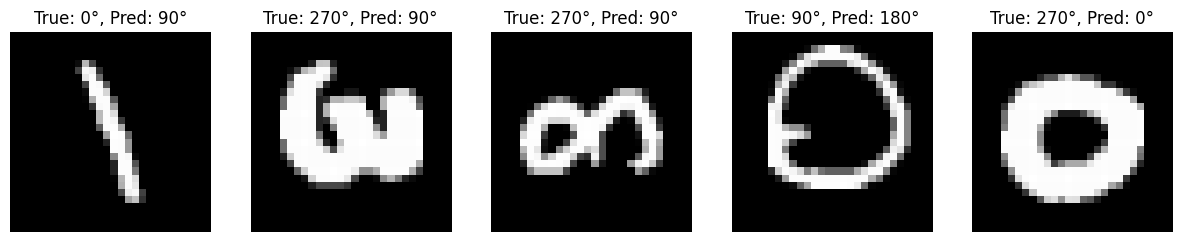

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets, transforms
import numpy as np

# Nastavení zařízení pro trénování (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definice rotace (self-supervised augmentace)
class RotationTransform:
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = int(np.random.choice(self.angles))  # Zajistíme, že úhel je typu int
        return transforms.functional.rotate(x, angle), angle

# Upravený MNIST dataset s rotacemi
class RotatedMNIST(datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super().__init__(root, train=train, transform=transform, target_transform=target_transform, download=download)
        self.rotation_transform = RotationTransform([0, 90, 180, 270])

    def __getitem__(self, index):
        img, _ = super().__getitem__(index)
        img, angle = self.rotation_transform(img)
        label = self.angles_to_label(angle)
        return img, label

    def angles_to_label(self, angle):
        if angle == 0:
            return 0
        elif angle == 90:
            return 1
        elif angle == 180:
            return 2
        elif angle == 270:
            return 3

# CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 4)  # 4 třídy výstupu (rotace 0, 90, 180, 270)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Transformace dat: převedení na tensor a normalizace
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Načtení trénovacího a testovacího datasetu
train_dataset = RotatedMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = RotatedMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Inicializace modelu, loss funkce a optimizeru
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Počet epoch pro trénink
num_epochs = 3

# Trénování modelu
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Dopředná fáze
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Zpětná propagace a aktualizace váh
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Výpis průměrné chyby po každé epoše
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

import matplotlib.pyplot as plt

# Testování modelu po každé epoše a zobrazení špatně detekovaných obrázků
model.eval()
correct = 0
total = 0
incorrect_images = []
incorrect_labels = []
incorrect_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Záznam špatně klasifikovaných obrázků
        incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]
        if len(incorrect_indices) > 0:
            incorrect_images.append(inputs[incorrect_indices].cpu())
            incorrect_labels.append(labels[incorrect_indices].cpu())
            incorrect_predictions.append(predicted[incorrect_indices].cpu())

# Výpis přesnosti po každé epoše
print(f'Test Accuracy: {100 * correct / total:.2f}%')

# Zobrazení špatně detekovaných obrázků
if incorrect_images:
    incorrect_images = torch.cat(incorrect_images)
    incorrect_labels = torch.cat(incorrect_labels)
    incorrect_predictions = torch.cat(incorrect_predictions)

    # Vykreslení prvních 5 špatně detekovaných obrázků
    num_images_to_show = min(5, incorrect_images.size(0))
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))

    for i in range(num_images_to_show):
        img = incorrect_images[i].squeeze()  # Odstranění rozměru kanálu
        label = incorrect_labels[i].item()
        prediction = incorrect_predictions[i].item()

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"True: {label*90}°, Pred: {prediction*90}°")
        axes[i].axis('off')

    plt.show()
else:
    print("No misclassified images found.")
